**Time to Build Something – End-to-end Machine Learning project using different machine learning algorithms**

* In this Notebook let's focus more on the models that we will use to predict the values and use the same data preparation we did in the previous notebook


Credits to this awesome exploration [*Notebook*](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [49]:
%run ./Data_preparation.ipynb
train , y , test = clean_data("train.csv","test.csv")

X_train = train.drop(['Id'],axis=1)
X_test = test.drop(['Id'],axis=1)

In [74]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [75]:
model_ridge = Ridge()

In [76]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

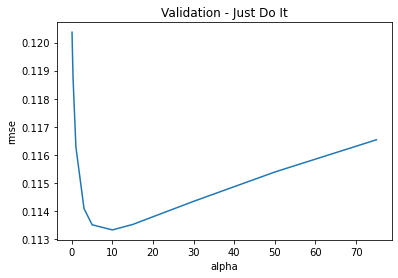

In [77]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [91]:
cv_ridge.min()

0.11333130999315214

In [84]:
cv_ridge.index[cv_ridge == cv_ridge.min()][0]

10.0

In [93]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.005]).fit(X_train,y)

In [95]:
rmse_cv(model_lasso).mean()

0.11408050073336266

In [96]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef

MSSubClass              -0.000262
LotArea                  0.000002
OverallQual              0.061592
OverallCond              0.044522
YearBuilt                0.002327
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.000000
SaleCondition_Normal     0.008479
SaleCondition_Partial    0.000000
Length: 220, dtype: float64

In [97]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 66 variables and eliminated the other 154 variables


In [98]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

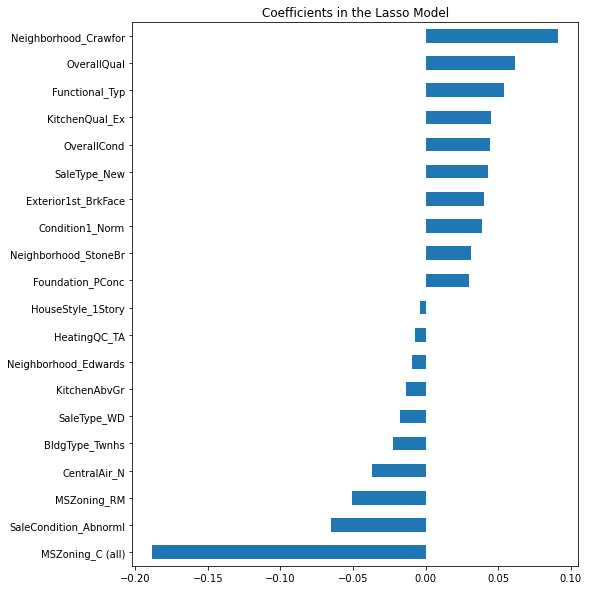

In [101]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

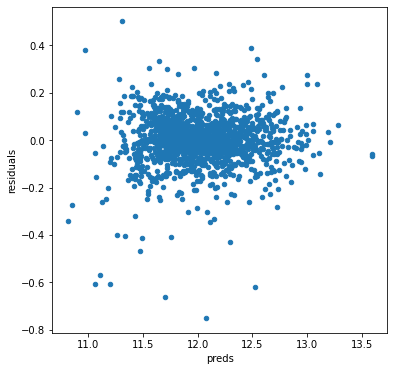

In [102]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [103]:
import xgboost as xgb

In [104]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

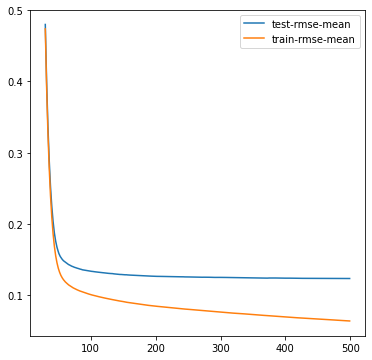

In [105]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [106]:
xgb.cv

<function xgboost.training.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[numpy.ndarray, numpy.ndarray]]] = None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]] = None)>

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [50]:
# from sklearn.tree import DecisionTreeRegressor
# simplest_model = DecisionTreeRegressor()
# simplest_reg = simplest_model.fit(X_train,y)
# predictions = simplest_reg.predict(X_test)
# predictions

In [51]:
# sub = pd.DataFrame()
# sub['Id'] = test.Id
# sub['SalePrice'] = np.expm1(predictions)
# sub.to_csv('submissions/4th_Simple.csv',index=False)

### We upload the csv in kaggle competition House Prices - Advanced Regression Techniques and we get a Score: 0.20745


#### In the meantime because the Notebook is pretty small I will try some more models just to test them!!

### Simple Ridge Model

In [85]:
from sklearn.linear_model import Ridge
simple_model = Ridge(alpha=10)
simple_reg = simple_model.fit(X_train,y)
predictions = simple_reg.predict(X_test)
predictions

array([11.66831201, 11.93008769, 12.09424687, ..., 12.01490661,
       11.66491   , 12.34439775])

In [86]:
sub = pd.DataFrame()
sub['Id'] = test.Id
sub['SalePrice'] = np.expm1(predictions)
sub.to_csv('submissions/Ridge_model_Regularized.csv',index=False)

In [87]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submissions/Ridge_model_Regularized.csv -m "Ridge_Regularized_alpha10"

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.1k [00:00<?, ?B/s]
 23%|##2       | 8.00k/35.1k [00:00<00:00, 53.0kB/s]
100%|##########| 35.1k/35.1k [00:01<00:00, 21.7kB/s]


### We upload the csv in kaggle competition House Prices - Advanced Regression Techniques and we get a Score: 0.13677


### Simple Lasso Model

In [54]:
# from sklearn.linear_model import Lasso
# simple_model = Lasso(alpha=.1)
# simple_reg = simple_model.fit(X_train,y)
# predictions = simple_reg.predict(X_test)
# predictions

In [55]:
# sub = pd.DataFrame()
# sub['Id'] = test.Id
# sub['SalePrice'] = np.expm1(predictions)
# sub.to_csv('submissions/Lasso_model.csv',index=False)

### We upload the csv in kaggle competition House Prices - Advanced Regression Techniques and we get a Score: 0.18470


### Bayesian Ridge

In [56]:
# from sklearn.linear_model import BayesianRidge
# simple_model = BayesianRidge()
# simple_reg = simple_model.fit(X_train,y)
# predictions = simple_reg.predict(X_test)
# predictions

In [57]:
# sub = pd.DataFrame()
# sub['Id'] = test.Id
# sub['SalePrice'] = np.expm1(predictions)
# sub.to_csv('submissions/Bayesian_Ridge_model.csv',index=False)

### We upload the csv in kaggle competition House Prices - Advanced Regression Techniques and we get a Score: 0.13252


### Random Forest

In [58]:
# from sklearn.ensemble import RandomForestRegressor
# simple_model = RandomForestRegressor()
# simple_reg = simple_model.fit(X_train,y)
# predictions = simple_reg.predict(X_test)
# predictions

In [59]:
# sub = pd.DataFrame()
# sub['Id'] = test.Id
# sub['SalePrice'] = np.expm1(predictions)
# sub.to_csv('submissions/Random_Forest_model.csv',index=False)

In [60]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submissions/Random_Forest_model.csv -m "Simple_Random_Forest_model"

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.1k [00:00<?, ?B/s]
 23%|##2       | 8.00k/35.1k [00:00<00:00, 50.9kB/s]
100%|##########| 35.1k/35.1k [00:01<00:00, 19.5kB/s]


In [88]:
test_csv = !kaggle competitions submissions -c house-prices-advanced-regression-techniques -v
for i,split in enumerate(test_csv):
    test_csv[i] = test_csv[i].split(",")
    
check_last = pd.DataFrame(test_csv,columns =test_csv[0])
check_last = check_last.iloc[2::2,:]
check_last = check_last.reset_index(drop=True)

In [89]:
check_last['publicScore'] = pd.to_numeric(check_last['publicScore'])


In [90]:
check_last['description'][check_last['publicScore'] == check_last['publicScore'].min()]

0    Ridge_Regularized_alpha10
Name: description, dtype: object